# spaCy Basics with Winnie Beam 
This notebook demonstrates various functionalities available through spaCy Python package for natural language processing, by applying it to the Winnie Beam Diary.

## What Can spaCy Do? 

- [Tokenization and (some) Lexical Attributes](#tokens-lex-atts)
    - Lexical attributes include:
        - Part-of-speech
        - Named Entity Recognition
        - Lemmatization (the root form of the word ex. buying and bought both have the lemma "buy")
        - *Morphological features (ex. verb form, mood, tense) (not covered in examples)
        - Noun chunks
        - Sentence segmentation
    - Also includes a little bit of info on displaCy and displaying dependency graphs and other types of displaCy visualizations.

-  [Matching with the `Matcher`](#matcher)
    - can match using the attributes determined by pipeline
        - entity types
        - parts of speech etc
    - this section presents some examples of that in Winnie Beam using the `Matcher` and the `DependencyMatcher` which matches using the dependency grammar structure
    - can specify custom callback functions for match rules (no code example, documentation with examples linked)
    - can match direct phrases with `PhraseMatcher` (not shown in examples)
        - useful for finite lists of things 

- [Word Vectors and Semantic Similarity](#word-vec-sem-sim)

- [Pipelines and Custom Components](#pipelines-components)
    - includes info on how to customize what processing is done by the NLP object
    - how to create custom components for the NLP pipeline 
    - how to efficiently process lots of documents

- [Training Models](#training)
    - some brief notes on sentiment analysis
    - a toy example of training a model using spacy, using a similar tiny dataset as presented in the Text Analysis basics workshop

- [Readability](#readability)
    - uses a spaCy Universe package (`TextDescriptives`) to quickly calculate a variety of text readability measures
    - brief notes about each score and how to interpret its results are presented, as well as an example for each 

In [ ]:
# install spacy 3.2.0 (any other 3.X version will likely work also)
!pip install spacy==3.2.0
# if doing anything with word vectors use en_core_web_md or higher as the language model
# run this cell then hit ctrl-m-. to restart the runtime then proceed
!python -m spacy download en_core_web_md

In [ ]:
# to check spacy version -- there are substantial differences between the 2.X and 3.X versions
!python -c "import spacy; print(spacy.__version__)"

In [ ]:
import spacy 
from spacy import displacy # for visualizing! 
# use "en_core_web_sm" if not using word vectors 
nlp = spacy.load("en_core_web_md") #change to "en_core_web_md" to use word vectors, this will take time to load in

# load pandas and matplotlib
import pandas as pd # for the dataframe
import matplotlib.pyplot as plt # for charting the analysis

# ensure our previews show lots of info
pd.set_option('display.max_colwidth', 999)

# get the corpus
winnie_corpus = pd.read_csv('https://raw.githubusercontent.com/BrockDSL/Text_Analysis_with_Python/master/winnie_corpus.txt', header = None, delimiter="\t")
# label the corpus dataframes
winnie_corpus.columns = ["page", "date", "entry"]
# change the data-type for date to be a date
winnie_corpus['date'] = pd.to_datetime(winnie_corpus['date'])
# change data-type for entries to be strings
winnie_corpus['entry'] = winnie_corpus.entry.astype(str)

# preview corpus
winnie_corpus.head()

,page,date,entry
0,7,1900-01-01,"New Year. First day of 1900 Charlie Merritt died at Grand Forks British Columbia yesterday of typhoid fever. To-day is election day and pap went up about 3 o'clock and did not get back until nearly 10. He brought us some candy chocolate drops. We had a very fat goose for dinner, not a very young one. Had to have good teeth."
1,7,1900-01-02,"Went uptown in afternoon. Was up to Eckardt's but Miss Macfarlane was not there so I did not get what I wanted. Called at office and Nettie came home with me for tea. Mr Carman came over and borrowed my Mildred books. Then Leta came & borrowed my German Grammar as she forgot hers & left it at school before holiday. Papa, mamma, Nettie & I played crokinole. Mamma & I beat. The 2nd Contingent left for Toronto today to go to South Africa. Dr King's som went."
2,8,1900-01-03,"Mrs Trusty was here washing School started to-day, but I was not going this week. Mamma went to the church and then to Mrs Chatfields Took her the church books. The queen Street Baptist church had a service of praise this evening. Mrs Chapman is organist & Mrs Read-Muir sang Mrs George Armstrong has a daughter was born on New Year's day."
3,8,1900-01-04,"Went over to Carman's to have Ella go with me to Dunn's greenhouse. We went about half past three. I brought a primrose Miss Chaplin was in there. Mamma went to Mrs Klotz at home Beatrice helped. Papa & I went to Sunday School entertainment at night. Had a very long programme. There was a dialogue called ""Aunt Ketty's shopping which was good, and a shaving scene. Mr perry gave a tableful of prizes away. Beatrice came home with us. They had a drill of girls & they sang ""Soldiers of the Queen"""
4,9,1900-01-05,"Sweep day. I read ""At the Camerons"" in the ""Harper's Young People"" when mamma was sweeping. We had a beggar in afternoon asking for a few cents as he had a long way to go. Rats! Went over to Lee's in afternoon after eggs. Took a ""Young Ladies Journal"" Mrs Pay lent me. Her kitty has a sore tail. Mrs Malcolmson came after eggs when I was there. She got large sum of 2. Had some candy at night."


<a name="tokens-lex-atts"></a>
## Tokenizing + Lexical Attributes



In [ ]:
entry = winnie_corpus.entry[0] # for the purposes of demonstration let's just look at this entry
doc = nlp(entry)

print("Original text: ", entry)
print()

for token in doc:
    print(token)

Original text:  New Year. First day of 1900 Charlie Merritt died at Grand Forks British Columbia yesterday of typhoid fever. To-day is election day and pap went up about 3 o'clock and did not get back until nearly 10. He brought us some candy chocolate drops. We had a very fat goose for dinner, not a very young one. Had to have good teeth.

New
Year
.
First
day
of
1900
Charlie
Merritt
died
at
Grand
Forks
British
Columbia
yesterday
of
typhoid
fever
.
To
-
day
is
election
day
and
pap
went
up
about
3
o'clock
and
did
not
get
back
until
nearly
10
.
He
brought
us
some
candy
chocolate
drops
.
We
had
a
very
fat
goose
for
dinner
,
not
a
very
young
one
.
Had
to
have
good
teeth
.


The tokenizer breaks down the text into tokens, these tokens are either words ("goose", "o'clock") or punctutation (".", ",").

Let's see some of the info we can get about these tokens! 


In [ ]:
print("Text\t Part-of-speech\t  Dependency\tLike-Number")
print()
for token in doc: 
    print(f"{token.text:<12}{token.pos_:<14}{token.dep_:<10}\t{token.like_num}")

Text	 Part-of-speech	  Dependency	Like-Number

New         PROPN         compound  	False
Year        PROPN         ROOT      	False
.           PUNCT         punct     	False
First       ADJ           amod      	True
day         NOUN          npadvmod  	False
of          ADP           prep      	False
1900        NUM           pobj      	True
Charlie     PROPN         compound  	False
Merritt     PROPN         nsubj     	False
died        VERB          ROOT      	False
at          ADP           prep      	False
Grand       PROPN         compound  	False
Forks       PROPN         compound  	False
British     PROPN         compound  	False
Columbia    PROPN         pobj      	False
yesterday   NOUN          npadvmod  	False
of          ADP           prep      	False
typhoid     NOUN          compound  	False
fever       NOUN          pobj      	False
.           PUNCT         punct     	False
To          ADP           nsubj     	False
-           PUNCT         punct     	False
day      

In [ ]:
# we can use this info to select certain types of tokens
# for example, only print nouns 
for token in doc:
    if token.pos_ == "NOUN": 
        print(token.text)

day
yesterday
typhoid
fever
day
election
day
pap
o'clock
candy
chocolate
goose
dinner
teeth


Each token has various attributes associated with it, that are determined and assigned as part of the NLP pipeline. Above we can see some of these attributes printed out, like the words' predicted part of speech and whether or not it is like a number (ex. "3" or "three"). 

The token attributes available will depend on what components are loaded into the NLP pipeline, which will be discussed further in the "Pipelines and Custom Components" section of the document. 

In addition to being able to break the document into tokens, we can also split it into sentences. (If you uncomment line 3, you'll also be able to view the dependency graphs for each sentence, which show how the words in the sentence connect to one another in the dependency grammar).

In [ ]:
# breaking the text into sentences instead, and trying to visualize them
for sent in doc.sents:
    # displacy.render(sent, style="dep", jupyter=True)
    print(sent)

New Year.
First day of 1900 Charlie Merritt died at Grand Forks British Columbia yesterday of typhoid fever.
To-day is election day and pap went up about 3 o'clock and did not get back until nearly 10.
He brought us some candy chocolate drops.
We had a very fat goose for dinner, not a very young one.
Had to have good teeth.


We can also look for named entities in the text

In [ ]:
# note that this model is detecting entities based on english text from the web
# as such it may not be perfect (also the predictions for the small and medium models may vary!) 
for ent in doc.ents:  
    print(ent.text, ent.label_)

New Year DATE
First day of DATE
Charlie Merritt PERSON
Grand Forks FAC
British Columbia GPE
yesterday DATE
nearly 10 CARDINAL


In [ ]:
# we can also visualize these using displaCy! 
displacy.render(doc, style="ent", jupyter=True)

For more info on what these predicted labels mean, we can use `spacy.explain()`

In [ ]:
spacy.explain("FAC")

'Buildings, airports, highways, bridges, etc.'

### Noun Chunks and Named Entities

In [ ]:
for chunk in doc.noun_chunks:
    print(chunk)

New Year
Charlie Merritt
Grand Forks British Columbia
typhoid fever
-day
election day
pap
He
us
some candy chocolate
We
a very fat goose
dinner
good teeth


In [ ]:
doc2 = nlp(winnie_corpus.entry[22]) # similar to, but distinct from the noun_phrases of TextBlob
for chunk in doc2.noun_chunks:
    print(chunk)

displacy.render(doc2,style="ent", jupyter=True) # note that the noun chunks are similar to, but distinct from the entities

school
the afternoon
papa mamma
I
The concert
I
anything
I
four singers 1 violinist
1 pianist
Mme Meredith soprano Miss Clary
contralto
Dr Carl Dufft
Mr Town, Tenor, Miss Von Fursch violinist and Miss Koler pianist
all
them
Mr Dufft
All the ladies
a beautiful boquet
The first part
L. Lehmann
a Persian Garden


In [ ]:
doc = nlp(winnie_corpus.entry[3])
print("Entities detected...")
for ent in doc.ents: 
    print(ent, "\t", ent.label_)

Entities detected...
Carman 	 PERSON
Ella 	 PERSON
Dunn 	 PERSON
Chaplin 	 PERSON
Mrs Klotz 	 PERSON
Beatrice 	 ORG
Papa & I 	 ORG
Sunday 	 DATE
night 	 TIME
Aunt Ketty's 	 WORK_OF_ART
perry 	 PERSON
Beatrice 	 PERSON
Soldiers of the Queen 	 WORK_OF_ART


<a name="matcher"></a>
## Using the Matcher

The Matcher is a really powerful tool in spaCy that allows you to use rule-based matching in your texts (this process can also be used to help speed up the process of creating labelled training examples for making custom machine learning based models). The Matcher can match on a variety of attributes in a document, including those created by spaCy's statistical models (like the part-of-speech tags). 

Below is a very small demo. 




In [ ]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab) # create the matcher

# create patterns to match
# here, we're looking for 1-2 proper nouns in a row
double_propn = [{"POS": "PROPN", }, {"POS":"PROPN","OP": "?" }] 
matcher.add("1-2PROPN", [double_propn], greedy="LONGEST") #setting greedy = longest we will only match the longest possible match in case of overlaps

doc = nlp(winnie_corpus.entry[3])

matches = matcher(doc)
print("Total matches found:", len(matches))

# Iterate over the matches and print the span text
for match_id, start, end in matches:
    print("Match found:", doc[start:end].text)

Total matches found: 12
Match found: Miss Chaplin
Match found: Mrs Klotz
Match found: Sunday School
Match found: Aunt Ketty
Match found: Mr perry
Match found: Carman
Match found: Ella
Match found: Dunn
Match found: Mamma
Match found: Beatrice
Match found: Papa
Match found: Beatrice


In [ ]:
# Attempting to apply matching on 1 or 2 proper nouns to the entire diary
docs = nlp.pipe(winnie_corpus.entry)
proper_noun_pairs = dict()
for doc in docs: 
    matches = matcher(doc)
    for match_id, start, end in matches:
        match_id_ = doc.vocab.strings[match_id] #retrieve the string for the match_id from the string store
        if match_id_ == "1-2PROPN":
            span_text = doc[start:end].text.lower()
            if span_text in proper_noun_pairs:
                proper_noun_pairs[span_text] += 1
            else:
                proper_noun_pairs[span_text] = 1

for key in sorted(proper_noun_pairs, key=proper_noun_pairs.get, reverse=True)[0:20]: 
    print(key, proper_noun_pairs[key])


mamma 330
papa 223
eva 81
sunday school 55
beatrice 53
mrs pay 40
lizzie 35
ella 33
mrs trusty 26
mr perry 26
lee 22
phoebe 22
mr read 21
dwyer 21
dr abbott 21
leta 20
mrs sullivan 19
toronto 18
church 18
mrs tulley 17


In [ ]:
# Trying the same as above but with the doc.ents
# Note: doc.ents are the entities predicted by the statistical language model,
#       this does not relate to the matcher, just an interesting point of comparison
docs = nlp.pipe(winnie_corpus.entry)
ent_frequencies = dict()
for doc in docs:
    for ent in doc.ents: 
        ent_ = ent.text.lower() # using the lowercase for case-insensitivity 
        if ent_ in ent_frequencies: 
            ent_frequencies[ent_]+= 1
        else: 
            ent_frequencies[ent_] = 1
for key in sorted(ent_frequencies, key=ent_frequencies.get, reverse=True)[0:20]: 
    print(key, ent_frequencies[key])

mamma 118
eva 75
night 56
afternoon 50
this morning 48
two 47
beatrice 45
yesterday 42
last night 37
lizzie 35
mamma & i 33
sunday 31
first 30
this afternoon 29
perry 26
morning 26
ella 25
mrs trusty 23
lee 23
dwyer 22


In [ ]:
# more complex application of a matching pattern. 
# 2 patterns are presented, uncomment line 10 to use both
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab) # create the matcher

# matching on 1 or more proper nouns or nouns, optionally any form of the word "be" and any form of death, die or dead
# you can also match on just mentions of death/dying but it is interesting to know who/what is being referenced 
death = [{"POS":{"IN": ["PROPN", "NOUN"]}, "OP":"+"}, {"OP":"?", "LEMMA": {"IN":["be", "is"]}}, {"LEMMA": {"IN": ["death", "die", "dead"]}}] 
# matcher.add("death", [death])
# another approach, the number of optional tokens was chosen somewhat at random, and it is fixed at 4 so that
#   entire entries are not matched 
person_death = [{"ENT_TYPE":"PERSON"}, {"OP":"?"}, {"OP":"?"}, {"OP":"?"}, {"OP":"?"}, {"LEMMA": {"IN": ["death", "die", "dead"]}}]
matcher.add("person-death", [person_death], greedy="LONGEST") #flag to only output the longest match 
docs = nlp.pipe(winnie_corpus.entry)

doc_num = 0

for doc in docs:
    matches = (matcher(doc))
    # Iterate over the matches and print the span text
    for match_id, start, end in matches:
        print("Match found in doc " +  str(doc_num) + ":", doc[start:end].text)
    doc_num += 1

Match found in doc 0: Charlie Merritt died
Match found in doc 7: Alice Boyle died
Match found in doc 14: Miss Fowler on Queen St. died
Match found in doc 21: O'Loughlin's mother died
Match found in doc 33: Senkler died
Match found in doc 42: Miss Vandenburg's mother died
Match found in doc 61: Mrs Dwyer was dying
Match found in doc 64: Mrs Dwyer died
Match found in doc 71: Mrs Jeeves died
Match found in doc 87: Joubert commander of Boer forces died
Match found in doc 121: Adam Borrowman died
Match found in doc 149: Rollinson is dead
Match found in doc 156: Wand is dead
Match found in doc 157: Leitch is dead
Match found in doc 184: R. Irwin who died
Match found in doc 186: R. Irwin who died
Match found in doc 205: Groome is dead
Match found in doc 247: Inksater's little boy is dead
Match found in doc 251: Sydney Bunting's mother died
Match found in doc 252: Henry King of Toronto is dead
Match found in doc 265: Mrs Milner died
Match found in doc 299: Mrs Keating died
Match found in doc 3

In [ ]:
# investigating some match results here
doc = nlp(winnie_corpus.entry[313])
displacy.render(doc, style="ent", jupyter="True")

In [ ]:
# further investigation, in the hopes of better (dependency based) matching patterns 
doc = nlp("Mrs. Kennedy of St. Louis died yesterday")
displacy.render(doc, style="dep", jupyter=True)

In [ ]:
# try to make similar matches using information from the dependency grammar
from spacy.matcher import DependencyMatcher
depMatcher = DependencyMatcher(nlp.vocab)
# this pattern was determined by examining the dependency grammar displayed in the example above
pattern = [ 
           {
               "RIGHT_ID": "anchor_died", # unique name for the node
               "RIGHT_ATTRS": {"LOWER": "died"} # token match pattern for "died"
           }, 
           {
               "LEFT_ID": "anchor_died", # the id for the node on the left (in this case, the anchor)
               "REL_OP": ">", # the anchor is the direct head of this node in the dep grammar
               "RIGHT_ID": "died_subject", # name for this node
               "RIGHT_ATTRS":{"DEP": "nsubj"}  # attributes for this token
           },
           {
                "LEFT_ID": "died_subject",
                "REL_OP": ">",
                "RIGHT_ID": "died_sub_modifier",
                "RIGHT_ATTRS": {"DEP": "compound"}
           }
]
depMatcher.add("DIED", [pattern])
# small test example 
doc = nlp("Mrs. Kennedy of St. Louis died yesterday")
matches = depMatcher(doc)
print(matches)

# an example of printing out match data
# each token_id corresponds to one pattern dict
match_id, token_ids = matches[0]
for i in range(len(token_ids)):
    print(pattern[i]["RIGHT_ID"] + ":", doc[token_ids[i]].text)

# get matches on the full text between the subject and the word died
start = min(token_ids)
end = max(token_ids)+1
print(doc[start:end])

[(3722395896039918763, [5, 1, 0])]
anchor_died: died
died_subject: Kennedy
died_sub_modifier: Mrs.
Mrs. Kennedy of St. Louis died


In [ ]:
# apply the above pattern at scale and see how it compares to our previous attempt
docs = nlp.pipe(winnie_corpus.entry)
doc_num = 0
for doc in docs:
    matches = (depMatcher(doc))
    # Iterate over the matches and print the span text
    for match_id, token_ids in matches:
        start = min(token_ids)
        end = max(token_ids)+1
        print("Match found in doc " +  str(doc_num) + ":", doc[start:end].text)
        # adding the precise matching info, to get a sense of how this is working 
        for i in range(len(token_ids)):
            print(pattern[i]["RIGHT_ID"] + ":", doc[token_ids[i]].text)
        print()
    doc_num += 1

Match found in doc 0: Charlie Merritt died
anchor_died: died
died_subject: Merritt
died_sub_modifier: Charlie

Match found in doc 7: niece Alice Boyle died
anchor_died: died
died_subject: Boyle
died_sub_modifier: niece

Match found in doc 7: Alice Boyle died
anchor_died: died
died_subject: Boyle
died_sub_modifier: Alice

Match found in doc 14: Miss Fowler on Queen St. died
anchor_died: died
died_subject: Fowler
died_sub_modifier: Miss

Match found in doc 64: Old Mrs Dwyer died
anchor_died: died
died_subject: Dwyer
died_sub_modifier: Old

Match found in doc 64: Mrs Dwyer died
anchor_died: died
died_subject: Dwyer
died_sub_modifier: Mrs

Match found in doc 71: Mrs Jeeves died
anchor_died: died
died_subject: Jeeves
died_sub_modifier: Mrs

Match found in doc 87: Joubert commander of Boer forces died
anchor_died: died
died_subject: commander
died_sub_modifier: Joubert

Match found in doc 121: Mrs Adam Borrowman died
anchor_died: died
died_subject: Borrowman
died_sub_modifier: Mrs

Match fou

In [ ]:
# investigating the structure of a particular match
doc = nlp("Mrs Pays niece Alice Boyle died on Sunday.")
displacy.render(doc, style="dep", jupyter=True)

In [ ]:
# exploring the dependencies for other kinds of sentences (captured by our previous match attempt)
doc = nlp("Henry King of Toronto is dead") # from 252
displacy.render(doc, style="dep", jupyter=True)

In [ ]:
# trying to match the above style and see if it matches the other "is dead" type matches from the previous approach
pattern = [ 
           {
               "RIGHT_ID": "anchor_is", # unique name for the node
               "RIGHT_ATTRS": {"LEMMA": "be"} # token match pattern for "be" / "is" / "was"
           }, 
           {
               "LEFT_ID": "anchor_is", # the id for the node on the left (in this case, the anchor)
               "REL_OP": ">", # the anchor is the direct head of this node in the dep grammar
               "RIGHT_ID": "is_state", # name for this node
               "RIGHT_ATTRS":{"DEP": "acomp"}  # attributes for this token
           },
           {
                "LEFT_ID": "anchor_is",
                "REL_OP": ">",
                "RIGHT_ID": "is_subject",
                "RIGHT_ATTRS": {"DEP": "nsubj"}
           },
           {
               "LEFT_ID": "is_subject",
                "REL_OP": ">",
                "RIGHT_ID":"subject_mod",
                "RIGHT_ATTRS": {"DEP":"compound"}
           }
]
depMatcher.add("IS_DEAD", [pattern])
# small test example 
doc = nlp(winnie_corpus.entry[156])
matches = depMatcher(doc)
print(len(matches))
for match_id, token_ids in matches:
    start = min(token_ids)
    end = max(token_ids)+1
    print("Match found:", doc[start:end].text)
    # adding the precise matching info, to get a sense of how this is working 
    for i in range(len(token_ids)):
        print(pattern[i]["RIGHT_ID"] + ":", doc[token_ids[i]].text)
    print()


## More Matching

- we can write match patterns to match on a number of different kinds of token attributes, the [Matcher API page](https://spacy.io/api/matcher) has a full list of the types of things it can match on but here is a short sampling
    - exact token text
        - "TEXT" 
    - lexical attributes
        - "LOWER" matches the lowercase text of the token to the pattern (which must itself be lowercase text) 
    - any token attribute (including predicted attributes)
        - "LEMMA" any word with that "root" ("LEMMA": "buy" would match "bought", "buying" etc)
        - "POS" part-of-speech
- we can also choose to match things 0, 1, or more times (note, notation is shortened here in all except example 1)
    - {"OP" : "!"} - negation match 0 times
    - "?" - optional, match 0 or 1 times
    - "+" - match 1 or more times
    - "*" - match 0 or more times
- matches are returned with the following 3 pieces of info (this format is really handy when using the matcher to "bootstrap" labelled training examples)
    - `match_id`: hash value of the pattern name 
    - `start` start index of the matched span
    - `end` end index of the matched span 
- can match on words + require them to be used as a certain POS (ex "duck" (verb) but not "duck" (noun))

Another interesting feature of the `Matcher` is the ability to specify a custom callback function for match rules. When adding a new rule to the `Matcher`, you can specify a function `on_match=function(matcher, doc, i, matches)` which will be evaluated after the `Matcher` has completed the process of matching on the document. The [on_match documentation](https://spacy.io/usage/rule-based-matching#on_match) demonstrates some interesting use-cases for this feature, including marking bad html tags for removal, or implementing a basic sentiment analyzer or automatically adding additional attribute information to matched spans.    

Explosion have a [rule-based Matcher Explorer](https://explosion.ai/demos/matcher) available on their website that can be helpful for creating match patterns and generally exploring how the Matcher behaves! 

Lastly, the [rule-based matching documentation](https://spacy.io/usage/rule-based-matching) is another helpul reference for all things matching related. 


In [ ]:
doc = nlp(winnie_corpus.entry[14])
displacy.render(doc, style="ent", jupyter="True")

<a name="word-vec-sem-sim"></a>
## Word Vectors + Semantic Similarity

In order to examine similarity, our model needs to contain word vectors. We need to load in at least the medium size model (`en_core_web_md`) to get those. 

Let's compare the "similarity" of two of Winnie's diary entries

In [ ]:
doc1 = nlp(winnie_corpus.entry[0])
doc2 = nlp(winnie_corpus.entry[1])
print(doc1.text)
print(doc2.text)
similarity = doc1.similarity(doc2)
print("Similarity: ", similarity)

New Year. First day of 1900 Charlie Merritt died at Grand Forks British Columbia yesterday of typhoid fever. To-day is election day and pap went up about 3 o'clock and did not get back until nearly 10. He brought us some candy chocolate drops. We had a very fat goose for dinner, not a very young one. Had to have good teeth.
Went uptown in afternoon. Was up to Eckardt's but Miss Macfarlane was not there so I did not get what I wanted. Called at office and Nettie came home with me for tea. Mr Carman came over and borrowed my Mildred books. Then Leta came & borrowed my German Grammar as she forgot hers & left it at school before holiday. Papa, mamma, Nettie & I played crokinole. Mamma & I beat. The 2nd Contingent left for Toronto today to go to South Africa. Dr King's som went.
Similarity:  0.9488148548475432


In [ ]:
# try comparing the same two entries with stop words removed
doc1 = nlp(winnie_corpus.entry[0])
doc2 = nlp(winnie_corpus.entry[1])
doc1 = nlp(' '.join([str(t) for t in doc1 if not t.is_stop]))
doc2 = nlp(' '.join([str(t) for t in doc2 if not t.is_stop]))
print(doc1.text)
print(doc2.text)
similarity = doc1.similarity(doc2)
print("Similarity: ", similarity)

New Year . day 1900 Charlie Merritt died Grand Forks British Columbia yesterday typhoid fever . - day election day pap went 3 o'clock nearly 10 . brought candy chocolate drops . fat goose dinner , young . good teeth .
Went uptown afternoon . Eckardt Miss Macfarlane wanted . Called office Nettie came home tea . Mr Carman came borrowed Mildred books . Leta came & borrowed German Grammar forgot & left school holiday . Papa , mamma , Nettie & played crokinole . Mamma & beat . 2nd Contingent left Toronto today South Africa . Dr King som went .
Similarity:  0.8874908273739859


We can also compare the similarity of individual tokens or groups of consecutive tokens (spans).

In [ ]:
# compare the similarity of the first token of doc1 and doc2
print("First token similarity:", doc1[0:1].similarity(doc2[0:1])) # tokens
# compare the similarity of the first sentences of doc1 and doc2
doc1_sentence = next(doc1.sents)
doc2_sentence = next(doc2.sents)
print("Opening sentence similarity:", doc1_sentence.similarity(doc2_sentence)) #spans

First token similarity: 0.29820922
Opening sentence similarity: 0.6196896


spaCy calculates similarity scores by comparing word vectors, which come pre-trained in the medium and large models. For a doc or span, this comparison is performed on the average of the token vectors. Some important things to note here:
- the meaning of multi-token phrases like "fast food" might not be captured since this is just averaging the word vectors of "fast" and "food" 
- this approach is insensitive to word order
- documents that have the same meaning but different wordings will likely return a lower similarity score than documents with similar wording and different meanings
- removing stop words or only focusing on nouns/proper nouns can sometimes be helpful for calculating similarity as it removes words which don't have a great deal of meaning/information within the overall text from being averaged into the similarity score

[More documentation on similarity](https://spacy.io/usage/linguistic-features#vectors-similarity). 

<a name="pipelines-components"></a>
## Pipelines + Custom Components 
We can customize the nlp pipeline that spacy uses to analyze the text, including by adding or removing components from it, or creating our own components.

In spaCy 3.X in order to create components you need to mark them with `@Language.component` or `@Language.factory` decorators (for function components and class components, respectively). In order to do this, we must first import `Language`. 

Below is a very simple example to automatically print the length of a processed document.

(For more detailed documentation, examples and ideas see the [processing pipeline documentation](https://spacy.io/usage/processing-pipelines))


In [ ]:
from spacy.language import Language

In [ ]:
if "length_component" in nlp.pipe_names: 
    nlp.remove_pipe("length_component")

@Language.component(name="length_component")
def length_component(doc): 
    doc_len = len(doc)
    print("This doc has", doc_len, "tokens.")
    return doc
if "length_component" not in nlp.pipe_names:
    nlp.add_pipe('length_component')
print(nlp.pipe_names)
doc = nlp(winnie_corpus.entry[0])

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'length_component']
This doc has 71 tokens.


In [ ]:
# Experimental and maybe not a best practice/not very reusable
lengths = [] 
@Language.component(name="exp_length_comp")
def exp_length_comp(doc):
    doc_len = len(doc)
    lengths.append(doc_len)
    return doc
if "length_component" in nlp.pipe_names: 
    nlp.remove_pipe("length_component")
nlp.add_pipe("exp_length_comp")

print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'exp_length_comp']



### Efficiently processing a lot of documents 

When you have a lot of documents that need processing, spaCy recommends using the `nlp.pipe()` method. For large collections of documents, this approach is significantly faster than processing the documents with a loop structure.

In [ ]:
# this cell relies on the exp_length_component being included in the pipeline
lengths = []
docs = list(nlp.pipe(winnie_corpus.entry)) # this creates a list of docs from each entry in the dataframe
print(lengths)

#add it to the dataframe
winnie_corpus['length'] = lengths

winnie_corpus.head()

[71, 101, 72, 109, 97, 110, 96, 102, 75, 121, 97, 97, 80, 100, 63, 94, 80, 92, 78, 90, 83, 86, 101, 82, 99, 120, 89, 86, 75, 93, 87, 93, 80, 95, 81, 91, 79, 101, 84, 87, 94, 119, 77, 92, 102, 100, 71, 98, 79, 97, 86, 92, 91, 101, 91, 99, 85, 112, 92, 102, 78, 91, 101, 94, 60, 110, 90, 85, 101, 107, 105, 97, 79, 102, 67, 89, 87, 61, 73, 73, 58, 93, 74, 90, 70, 71, 85, 108, 78, 89, 109, 112, 107, 67, 88, 82, 82, 116, 91, 102, 76, 93, 105, 85, 70, 99, 96, 103, 103, 89, 73, 63, 94, 127, 79, 91, 93, 99, 100, 111, 76, 78, 102, 104, 71, 77, 55, 94, 63, 93, 76, 72, 66, 111, 101, 93, 82, 101, 76, 62, 100, 116, 97, 135, 125, 70, 66, 95, 116, 108, 104, 90, 91, 102, 68, 62, 97, 84, 91, 71, 85, 95, 75, 81, 90, 109, 74, 104, 62, 99, 52, 108, 86, 99, 81, 73, 86, 83, 84, 85, 61, 66, 75, 84, 75, 81, 92, 78, 81, 75, 90, 84, 83, 99, 89, 60, 85, 121, 103, 75, 79, 76, 91, 88, 64, 83, 89, 116, 86, 123, 76, 101, 75, 99, 103, 83, 57, 111, 82, 79, 65, 96, 61, 85, 93, 87, 68, 86, 68, 53, 74, 111, 84, 77, 73, 79

,page,date,entry,length
0,7,1900-01-01,"New Year. First day of 1900 Charlie Merritt died at Grand Forks British Columbia yesterday of typhoid fever. To-day is election day and pap went up about 3 o'clock and did not get back until nearly 10. He brought us some candy chocolate drops. We had a very fat goose for dinner, not a very young one. Had to have good teeth.",71
1,7,1900-01-02,"Went uptown in afternoon. Was up to Eckardt's but Miss Macfarlane was not there so I did not get what I wanted. Called at office and Nettie came home with me for tea. Mr Carman came over and borrowed my Mildred books. Then Leta came & borrowed my German Grammar as she forgot hers & left it at school before holiday. Papa, mamma, Nettie & I played crokinole. Mamma & I beat. The 2nd Contingent left for Toronto today to go to South Africa. Dr King's som went.",101
2,8,1900-01-03,"Mrs Trusty was here washing School started to-day, but I was not going this week. Mamma went to the church and then to Mrs Chatfields Took her the church books. The queen Street Baptist church had a service of praise this evening. Mrs Chapman is organist & Mrs Read-Muir sang Mrs George Armstrong has a daughter was born on New Year's day.",72
3,8,1900-01-04,"Went over to Carman's to have Ella go with me to Dunn's greenhouse. We went about half past three. I brought a primrose Miss Chaplin was in there. Mamma went to Mrs Klotz at home Beatrice helped. Papa & I went to Sunday School entertainment at night. Had a very long programme. There was a dialogue called ""Aunt Ketty's shopping which was good, and a shaving scene. Mr perry gave a tableful of prizes away. Beatrice came home with us. They had a drill of girls & they sang ""Soldiers of the Queen""",109
4,9,1900-01-05,"Sweep day. I read ""At the Camerons"" in the ""Harper's Young People"" when mamma was sweeping. We had a beggar in afternoon asking for a few cents as he had a long way to go. Rats! Went over to Lee's in afternoon after eggs. Took a ""Young Ladies Journal"" Mrs Pay lent me. Her kitty has a sore tail. Mrs Malcolmson came after eggs when I was there. She got large sum of 2. Had some candy at night.",97


In [ ]:
nlp.remove_pipe("exp_length_comp")
# nlp.remove_pipe("length_component")

('exp_length_comp', <function __main__.exp_length_comp>)

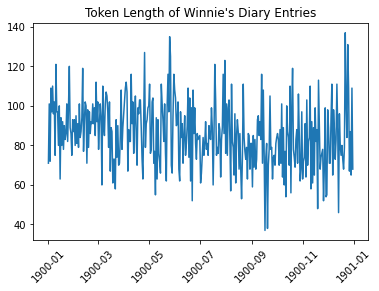

In [ ]:
# graphing the length, just to see
plt.plot(winnie_corpus["date"], winnie_corpus["length"])
plt.xticks(rotation='45')
plt.title("Token Length of Winnie's Diary Entries")
plt.show()

## Extension Attributes
Allow you to add custom metadata to docs, spans, and tokens.

This metadata can be attributes (with default values you can overwrite), properties (which can be dynamically determined with getters and setters), or methods. For more information on extension attributes, see: [spaCy documentation: Custom Attributes](https://spacy.io/usage/processing-pipelines#custom-components-attributes)


<a name="training"></a>
# Training Your Own Models 
Useful for named entity recognition (NER) especially. 
Learn classification schemes specific to your problem. 
Many components of the spaCy pipeline are trainable, allowing you to train them from scratch or tweak an existing model to work better for your needs.

Below we look at training a new model to do basic sentiment analysis using a very small dataset. This isn't a practical example so much as a demonstration of the basic process of training a spaCy model. 

Each pipeline component will indicate on its [API page](https://spacy.io/api) whether or not it is a trainable component and give some information on how training that component works. For the example below, we'll be using the [TextCategorizer](https://spacy.io/api/textcategorizer).

For a more detailed overview of how training works see [the spaCy training documentation](https://spacy.io/usage/training). 

# Sentiment Analysis
The two main approaches I have seen for this are: combine spaCy with TextBlob (a [spaCyTextBlob library](https://github.com/SamEdwardes/spaCyTextBlob) exists to integrate TextBlob as a pipeline component, though you can also do it yourself), or train spaCy's text classifier yourself with a lot of labelled data. 

Another option is to update an existing model instead of starting from scratch with a new model, this method still requires a good bit of labelled data, but much less than starting from scratch. 

## Text Classifiers, generally

Basing this code off of [this tutorial](https://medium.com/analytics-vidhya/building-a-text-classifier-with-spacy-3-0-dd16e9979a) as well as these [spaCy](https://spacy.io/usage/training) [docs](https://spacy.io/api/textcategorizer)

In [ ]:
from spacy.tokens import DocBin # allows us to save our training data in a compact format, easily read by the system 

In [ ]:
# make the documents to use as training info

def make_docbin(data, path):
    """
    this will take a list of texts and labels 
    and transform them into spacy documents
    data: list(tuple(text, label))
    path: file path to save to
    """
    db = DocBin()
    for doc, label in nlp.pipe(data, as_tuples=True):
        # give the appropriate training value
        if label == 'sub':
            doc.cats["objective"] = False
            doc.cats["subjective"] = True
        else:
            doc.cats["objective"] = True
            doc.cats["subjective"] = False
        # add the document to the list
        db.add(doc)
    db.to_disk(path)
    

In [ ]:
train = [
    ('I think Twitter is stupid', 'sub'),
    ('Lots of people send too much time on Twitter.', 'obj'),
    ('Twitter is a waste of time.', 'sub'),
    ('Twitter can be used to find information.', 'obj'),
    ('Many celebrites have Twitter accounts.', 'obj'),
    ('I think there is too much misinformation on Twitter', 'sub'),
    ("I don't like Twitter.", 'sub'),
    ("Twitter is the best ever", 'sub'),
    ('Twitter is great because all of my friends us it', 'sub'),
    ('Twitter is a fortune 500 company', 'obj')
    ]

test = [
     ('Twitter is a company', 'obj'),
     ("You can't communicate well with such short sentences", 'sub'),
     ("Twitter is disruptive to soceity", 'sub'),
     ("Over 500 million people use Twitter", 'obj'),
     ('A Twitter message can have 280 characters', 'obj'),
     ("A Twitter message is always stupid", 'sub')
    ]

In [ ]:
# before running this make sure you add a "data" folder to your files pane on the left
make_docbin(train, "./data/train.spacy")
make_docbin(test, "./data/test.spacy")

Now that we have the binary data, we can set up training for the model via a `config` file. We can create a default config file using the [config file generator](https://spacy.io/usage/training#quickstart) on the spaCy website. 

For this we'll use the settings: English, CPU, textcat (exclusive categories), efficiency. Download the file from the spaCy website. Then upload this file to the files pane on the left and double click to open it. Add the appropriate paths to the train and test data at the top of the file under `[paths]`

i.e.
```
[paths]
train = "data/train.spacy"
dev = "data/test.spacy"
```

Run the following command to ensure the config file contains all the required values. 



In [ ]:
!python -m spacy init fill-config base_config.cfg config.cfg --diff

Once this is done we can edit the config.cfg file to add the appropriate paths to our stored train and test data. We can then proceed with training our model. 

Since this is a very small dataset I am going to try to change the `patience` to 10 and the `eval_frequency` to 5 in the `config` and see what happens. 

Note: you can also make small on-the-fly changes to params etc from the `config` within the CLI, so you don't have to alter your config file to mess around with some hyperparameters etc. Can also use this method for setting the train/test/output paths 

Ex `!python -m spacy train config.cfg --paths.train ./data/train.spacy --paths.dev ./data/valid.spacy --output ./output`



In [ ]:
!python -m spacy train config.cfg --output ./output

Now that we have a trained model, let's test it out on some data to see how it does! 

In [ ]:
# load the model 
nlp = spacy.load("output/model-last") # this is from the above output where it tells us where it stored our trained pipeline

doc_label = "Document Text"
obj_label = "obj"
sub_label = "sub"
true_label = "True Label"
predict = "Prediction"
space = ""
print(f"{doc_label:53}{obj_label:10}{sub_label:10}{true_label:11}{predict:11}")
for doc, label in nlp.pipe(test, as_tuples=True):
    predicted_label ='obj' if doc.cats['objective']>= 0.5 else 'sub'
    print(f"{doc.text:53}{doc.cats['objective']:1.4}{space:5}{doc.cats['subjective']:1.4}{space:5}{label:11}{predicted_label:11}")



In [ ]:
clean_test = [
    ('Twitter messages used to be limited to 140 characters', 'obj'),
    ('Nothing good ever happens on Twitter','sub'),
    ('Twitter is the worst kind of social media', 'sub'),
    ('Twitter is the best social media', 'sub'),
    ('Twitter was founded in 2006', 'obj'), 
    ('Messages posted to Twitter are called tweets', 'obj')              
]

In [ ]:
print(f"{doc_label:53}{obj_label:10}{sub_label:10}{true_label:11}{predict:11}")
for doc, label in nlp.pipe(clean_test, as_tuples=True):
    predicted_label ='obj' if doc.cats['objective']>= 0.5 else 'sub'
    print(f"{doc.text:53}{doc.cats['objective']:1.3}{space:5}{doc.cats['subjective']:1.3}{space:5}{label:11}{predicted_label:11}")

<a name="readability"></a>
# Readability

The package [`TextDescriptives`](https://github.com/HLasse/TextDescriptives) is a spaCy add-on that adds readability calculations amongst other descriptive stats metrics. We will use this package to calculate a variety of readability scores for our text.
[Documentation for the readability section](https://hlasse.github.io/TextDescriptives/readability.html) of the package.


In [ ]:
!pip install textdescriptives

In [ ]:
import spacy 
import textdescriptives as td
nlp = spacy.load("en_core_web_md")
nlp.add_pipe("textdescriptives")

In [ ]:
doc = nlp(winnie_corpus.entry[0])
# readability statistics can be accessed either through 
doc._.readability
# or through a dataframe 
td.extract_df(doc, metrics="readability") #allows you to specify which metrics to calculate

,text,flesch_reading_ease,flesch_kincaid_grade,smog,gunning_fog,automated_readability_index,coleman_liau_index,lix,rix
0,"New Year. First day of 1900 Charlie Merritt died at Grand Forks British Columbia yesterday of typhoid fever. To-day is election day and pap went up about 3 o'clock and did not get back until nearly 10. He brought us some candy chocolate drops. We had a very fat goose for dinner, not a very young one. Had to have good teeth.",100.830538,1.762581,5.461319,4.778495,2.652634,4.950323,24.849462,1.5


## Flesch-Kincaid Tests
### [Flesch Reading Ease](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease)
- the higher the score, the easier the text is to read, to get a break down, see the table below ([source](https://web.archive.org/web/20160712094308/http://www.mang.canterbury.ac.nz/writing_guide/writing/flesch.shtml)). 

| Score  | School Level                | Notes            |
|--------|-----------------------------|------------------|
| 90-100 | 5th grade                   | Very easy.       |
| 80-90  | 6th grade                   | Easy.            |
| 70-80  | 7th grade                   | Fairly easy.     |
| 60-70  | 8th-9th grade               | Plain English.   |
| 50-60  | 10th-12th grade             | Fairly difficult |
| 30-50  | College/University          | Difficult.       |
| 0-30   | College/University graduate | Very difficult.  |
<br> 


- the formula used to calculate this score is:
\begin{equation}
206.835 - 1.015 \bigg(\frac{\text{total words}}{\text{total sentences}}\bigg) - 84.6 \bigg(\frac{\text{total syllables}}{\text{total words}}\bigg)
\end{equation}


In [ ]:
# example usage
doc = nlp(winnie_corpus.entry[0])
doc._.readability["flesch_reading_ease"]

100.8305376344086

### [Flesch-Kincaid Grade Level](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level)
- this test builds upon the Flesch Reading Ease test, and instead approximates the US grade level needed to understand the text 
- the result is the approximate grade level or number of years of education required to understand the text
- the formula is 


\begin{equation}
0.39 \bigg(\frac{\text{total words}}{\text{total sentences}}\bigg) + 11.8 \bigg(\frac{\text{total syllables}}{\text{total words}}\bigg) - 15.59
\end{equation}

In [ ]:
# example usage
doc = nlp(winnie_corpus.entry[0])
doc._.readability["flesch_kincaid_grade"]

1.762580645161293

## [SMOG Readability](https://en.wikipedia.org/wiki/SMOG)
- SMOG stands for "Simple Measure of Goobledygook" 
- validation studies have shown that this measure has a strong correlation (r=0.985) with the actual grade level required for complete comprehension of the text
- popularly used for assessing readability of health care information  
- to calculate
    - count a number of sentences (min. 30)
    - count the polysyllables (words of 3 or more syllables) in those sentences
    - apply the following formula
    \begin{equation}
    \text{grade} = 1.0430 \sqrt{\text{number of polysyllables} \times \frac{30}{\text{number of sentences}}} + 3.1291
    \end{equation}


In [ ]:
# example usage
doc = nlp(winnie_corpus.entry[0])
doc._.readability["smog"]

5.46131890053228

## [Coleman-Liau Index](https://en.wikipedia.org/wiki/Coleman%E2%80%93Liau_index)
- based on the number of characters per word (instead of the number of syllables common in other methods) 
- formula, where $L$ is average number of letters per 100 words, $S$ is average number of sentences per 100 words
\begin{equation}
CLI = 0.0588L - 0.296S -15.8 
\end{equation}

In [ ]:
# example usage
doc = nlp(winnie_corpus.entry[0])
doc._.readability["coleman_liau_index"]

4.950322580645164

## [Automated Readability Index](https://en.wikipedia.org/wiki/Automated_readability_index)
- approximates US grade level needed to understand a text
- like Coleman-Liau, based on number of characters instead of number of syllables (the accuracy of this vs syllable-based methods is debated, but this is much faster and easier to compute)
- non-integer scores are always rounded up to the next whole integer (take the ceiling of the score)

\begin{equation}
4.71 \bigg(\frac{\text{characters}}{\text{words}} + 0.5 \frac{\text{words}}{\text{sentences}} - 21.43\bigg)
\end{equation}

- the resulting scores correspond with this table 

| Score | Age   | Grade Level  |
|-------|-------|--------------|
| 1     | 5-6   | Kindergarten |
| 2     | 6-7   | 1st Grade    |
| 3     | 7-8   | 2nd Grade    |
| 4     | 8-9   | 3rd Grade    |
| 5     | 9-10  | 4th Grade    |
| 6     | 10-11 | 5th Grade    |
| 7     | 11-12 | 6th Grade    |
| 8     | 12-13 | 7th Grade    |
| 9     | 13-14 | 8th Grade    |
| 10    | 14-15 | 9th Grade    |
| 11    | 15-16 | 10th Grade   |
| 12    | 16-17 | 11th Grade   |
| 13    | 17-18 | 12th Grade   |
| 14    | 18-22 | College      |
<br>



In [ ]:
# example usage
doc = nlp(winnie_corpus.entry[0])
doc._.readability["automated_readability_index"]

2.652634408602154

## [Gunning fog index (AKA the fog index)](https://en.wikipedia.org/wiki/Gunning_fog_index)

The Gunning-fog index is a test for English writing which calculates the approximate number of years of formal education that a person needs to be able to understand a text. 

To calculate the Gunning fog index: 
- Select a passage of around 100 words in length
- Count the number of "complex words". A complex word is one which consists of 3 or more syllables, excluding proper nouns and compound words. Do not include common suffixes (like -es, -ed, or -ing) in syllable counts
- Apply the following formula
\begin{equation}
0.4 \bigg[\bigg(\frac{\text{words}}{\text{sentences}}\bigg) + 100 \bigg(\frac{\text{complex words}}{\text{words}}\bigg) \bigg]
\end{equation}

The results of the Gunning fog index can be interpretted using the following table: 

| Fog Index |  Grade Level        |
|-----------|---------------------|
| 6         |  Grade 6            |
| 7         |  Grade 7            |
| 8         |  Grade 8            |
| 9         |  Grade 9            |
| 10        |  Grade 10           |
| 11        |  Grade 11           |
| 12        |  Grade 12           |
| 13        |  College - 1st year |
| 14        |  College - 2nd year |
| 15        |  College - 3rd year |
| 16        |  College - 4th year |
| 17        |  College Graduate   |

In [ ]:
# example usage
doc = nlp(winnie_corpus.entry[0])
doc._.readability["gunning_fog"]

4.778494623655915

# Lix and Rix
These two readability formulas employ character counting as opposed to syllable counting and have been used on a variety of texts and found to be reliable for English as well as several other languages.

## Lix

Lix is a readability formula developed in Sweden. It has been shown to be reliable for a variety of age ranges, from elementary school age children to adults.

The Lix formula is defined as follows: 
\begin{equation}
\frac{\text{number of long words × 100}}{\text{number of words}} + \frac{\text{number of words}}{\text{number of sentences}}
\end{equation}

Lix scores can be interpretted for English as follows: 

| Lix Score     |  Grade Level        |
|---------------|---------------------|
| below 10      |  Grade 1            |
| 10 - 14       |  Grade 2            |
| 15 - 19       |  Grade 3            |
| 20 - 23       |  Grade 4            |
| 24 - 27       |  Grade 5            |
| 28 - 31       |  Grade 6            |
| 32 - 35       |  Grade 7            |
| 36 - 39       |  Grade 8            |
| 40 - 43       |  Grade 9            |
| 44 - 47       |  Grade 10           |
| 48 - 51       |  Grade 11           |
| 52 - 55       |  Grade 12           |
| 56 of higher  |  College            |



In [ ]:
# example usage
doc = nlp(winnie_corpus.entry[0])
doc._.readability["lix"]

24.8494623655914

## Rix

Rix is a variation on the Lix readability measure, this measure has been simplified and adapted to be well suited to quickly assessing the grade level of English reading materials. 

The Rix formula is as follows: 
\begin{equation}
\frac{\text{number of long words}}{\text{number of sentences}}
\end{equation}

For this formula, a word is defined as a sequence of characters surrounded by whitespace. A "long word" is defined as a word of 7 or more characters (excluding hyphens, punctuation marks, or brackets). 

The output of Rix can be interpretted using the following table: 

| Rix Score     |  Grade Level        |
|---------------|---------------------|
| below 0.2     |  Grade 1            |
| 0.2 and above |  Grade 2            |
| 0.5 and above |  Grade 3            |
| 0.8 and above |  Grade 4            |
| 1.3 and above |  Grade 5            |
| 1.8 and above |  Grade 6            |
| 2.4 and above |  Grade 7            |
| 3.0 and above |  Grade 8            |
| 3.7 and above |  Grade 9            |
| 4.5 and above |  Grade 10           |
| 5.3 and above |  Grade 11           |
| 6.2 and above |  Grade 12           |
| 7.2 and above |  College            |


Sources: 
https://www.jstor.org/stable/40031755 <br>
https://readable.com/blog/the-lix-and-rix-readability-formulas/ <br>
https://hlasse.github.io/TextDescriptives/readability.html

In [ ]:
# example usage
doc = nlp(winnie_corpus.entry[0])
doc._.readability["rix"]

1.5

In [ ]:
# TextDescriptives makes it super easy to quickly calculate a group of desired metrics 
# and display them in a pandas dataframe! 
# here we create a generator of docs using nlp.pipe on all the entries of the diary
docs = nlp.pipe(winnie_corpus.entry)
# and we give that generator of docs to TextDescriptives to get the readability scores.
read_data = td.extract_df(docs, metrics="readability")

In [ ]:
# remove the text from the readability data
read_data = read_data.drop(columns='text')
# add the readability scores to the winnie dataframe
result = pd.merge(winnie_corpus, read_data, left_index=True, right_index=True)
result.head()

,page,date,entry,length,flesch_reading_ease,flesch_kincaid_grade,smog,gunning_fog,automated_readability_index,coleman_liau_index,lix,rix
0,7,1900-01-01,"New Year. First day of 1900 Charlie Merritt died at Grand Forks British Columbia yesterday of typhoid fever. To-day is election day and pap went up about 3 o'clock and did not get back until nearly 10. He brought us some candy chocolate drops. We had a very fat goose for dinner, not a very young one. Had to have good teeth.",71,100.830538,1.762581,5.461319,4.778495,2.652634,4.950323,24.849462,1.5
1,7,1900-01-02,"Went uptown in afternoon. Was up to Eckardt's but Miss Macfarlane was not there so I did not get what I wanted. Called at office and Nettie came home with me for tea. Mr Carman came over and borrowed my Mildred books. Then Leta came & borrowed my German Grammar as she forgot hers & left it at school before holiday. Papa, mamma, Nettie & I played crokinole. Mamma & I beat. The 2nd Contingent left for Toronto today to go to South Africa. Dr King's som went.",101,90.544714,2.716952,7.168622,5.740952,2.563214,5.386190,21.495238,1.1
2,8,1900-01-03,"Mrs Trusty was here washing School started to-day, but I was not going this week. Mamma went to the church and then to Mrs Chatfields Took her the church books. The queen Street Baptist church had a service of praise this evening. Mrs Chapman is organist & Mrs Read-Muir sang Mrs George Armstrong has a daughter was born on New Year's day.",72,91.477321,4.412817,5.985473,6.934921,6.481190,7.333968,31.623016,2.5
3,8,1900-01-04,"Went over to Carman's to have Ella go with me to Dunn's greenhouse. We went about half past three. I brought a primrose Miss Chaplin was in there. Mamma went to Mrs Klotz at home Beatrice helped. Papa & I went to Sunday School entertainment at night. Had a very long programme. There was a dialogue called ""Aunt Ketty's shopping which was good, and a shaving scene. Mr perry gave a tableful of prizes away. Beatrice came home with us. They had a drill of girls & they sang ""Soldiers of the Queen""",109,99.053445,1.704055,4.935629,4.079560,2.943407,5.694945,23.385714,1.3
4,9,1900-01-05,"Sweep day. I read ""At the Camerons"" in the ""Harper's Young People"" when mamma was sweeping. We had a beggar in afternoon asking for a few cents as he had a long way to go. Rats! Went over to Lee's in afternoon after eggs. Took a ""Young Ladies Journal"" Mrs Pay lent me. Her kitty has a sore tail. Mrs Malcolmson came after eggs when I was there. She got large sum of 2. Had some candy at night.",97,102.436753,0.934038,5.683918,4.172658,0.107975,2.410127,15.494937,0.6


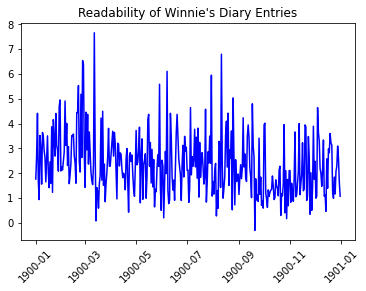

In [ ]:
# plot the flesch-kincaid grade level over time (to see if it fluctuates or stays steady)
plt.plot(result["date"], result["flesch_kincaid_grade"], color='blue')
plt.xticks(rotation='45')
plt.title("Readability of Winnie's Diary Entries")
plt.show()

In [ ]:
lengths = []
# docs is a generator and not a list, so you can only use it once unless you make it a list(docs)
docs = nlp.pipe(winnie_corpus.entry)
for doc in docs: 
    lengths.append(doc.__len__())
result['length'] = lengths
result.head()

,page,date,entry,length,flesch_reading_ease,flesch_kincaid_grade,smog,gunning_fog,automated_readability_index,coleman_liau_index,lix,rix
0,7,1900-01-01,"New Year. First day of 1900 Charlie Merritt died at Grand Forks British Columbia yesterday of typhoid fever. To-day is election day and pap went up about 3 o'clock and did not get back until nearly 10. He brought us some candy chocolate drops. We had a very fat goose for dinner, not a very young one. Had to have good teeth.",71,100.830538,1.762581,5.461319,4.778495,2.652634,4.950323,24.849462,1.5
1,7,1900-01-02,"Went uptown in afternoon. Was up to Eckardt's but Miss Macfarlane was not there so I did not get what I wanted. Called at office and Nettie came home with me for tea. Mr Carman came over and borrowed my Mildred books. Then Leta came & borrowed my German Grammar as she forgot hers & left it at school before holiday. Papa, mamma, Nettie & I played crokinole. Mamma & I beat. The 2nd Contingent left for Toronto today to go to South Africa. Dr King's som went.",101,90.544714,2.716952,7.168622,5.740952,2.563214,5.386190,21.495238,1.1
2,8,1900-01-03,"Mrs Trusty was here washing School started to-day, but I was not going this week. Mamma went to the church and then to Mrs Chatfields Took her the church books. The queen Street Baptist church had a service of praise this evening. Mrs Chapman is organist & Mrs Read-Muir sang Mrs George Armstrong has a daughter was born on New Year's day.",72,91.477321,4.412817,5.985473,6.934921,6.481190,7.333968,31.623016,2.5
3,8,1900-01-04,"Went over to Carman's to have Ella go with me to Dunn's greenhouse. We went about half past three. I brought a primrose Miss Chaplin was in there. Mamma went to Mrs Klotz at home Beatrice helped. Papa & I went to Sunday School entertainment at night. Had a very long programme. There was a dialogue called ""Aunt Ketty's shopping which was good, and a shaving scene. Mr perry gave a tableful of prizes away. Beatrice came home with us. They had a drill of girls & they sang ""Soldiers of the Queen""",109,99.053445,1.704055,4.935629,4.079560,2.943407,5.694945,23.385714,1.3
4,9,1900-01-05,"Sweep day. I read ""At the Camerons"" in the ""Harper's Young People"" when mamma was sweeping. We had a beggar in afternoon asking for a few cents as he had a long way to go. Rats! Went over to Lee's in afternoon after eggs. Took a ""Young Ladies Journal"" Mrs Pay lent me. Her kitty has a sore tail. Mrs Malcolmson came after eggs when I was there. She got large sum of 2. Had some candy at night.",97,102.436753,0.934038,5.683918,4.172658,0.107975,2.410127,15.494937,0.6


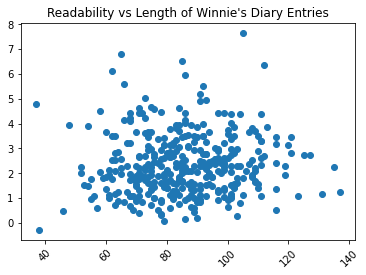

In [ ]:
# plot the flesch-kincaid grade level versus the length of the entries to see if there is a relationship
plt.scatter(result["length"], result['flesch_kincaid_grade'])
plt.xticks(rotation='45')
plt.title("Readability vs Length of Winnie's Diary Entries")
plt.show()

# Miscellaneous: TextDescriptives
Since we are already using `TextDescriptives`, here's a look at some of the other attributes it can calculate:

## [Descriptive Statistics](https://hlasse.github.io/TextDescriptives/descriptivestats.html)
The following attributes can be calculated for a complete `Doc`:
- `Doc._.token_length`
    - mean, median and standard deviation of token length
- `Doc._.sentence_length`
    - mean, median and standard deviation of sentence length
- `Doc._.syllables`
    - mean, median and standard deviation of number of syllables per token 
- `Doc._.counts`
    - number of tokens, number of unique tokens, proportion of unique tokens, number of characters

For a `Span`, we can calculate: 
- `Span._.token_length`
- `Span._.counts`

These operate in the same manner as their `Doc` counterparts, only on a specified `Span` object.


In [ ]:
doc = nlp(winnie_corpus.entry[0])
# extracting all of the descriptive stats for this entry into a dataframe
# could also get them as dictionaries by using the doc attributes listed above
td.extract_df(doc, metrics="descriptive_stats", include_text=False)

,token_length_mean,token_length_median,token_length_std,sentence_length_mean,sentence_length_median,sentence_length_std,syllables_per_token_mean,syllables_per_token_median,syllables_per_token_std,n_tokens,n_unique_tokens,proportion_unique_tokens,n_characters,n_sentences
0,4.016129,4.0,1.938506,10.333333,10.0,6.101002,1.129032,1.0,0.380317,62,53,0.854839,264,6


In [ ]:
docs = nlp.pipe(winnie_corpus.entry)
winnie_stats = td.extract_df(docs, metrics="descriptive_stats", include_text=False)
winnie_stats

,token_length_mean,token_length_median,token_length_std,sentence_length_mean,sentence_length_median,sentence_length_std,syllables_per_token_mean,syllables_per_token_median,syllables_per_token_std,n_tokens,n_unique_tokens,proportion_unique_tokens,n_characters,n_sentences
0,4.016129,4.0,1.938506,10.333333,10.0,6.101002,1.129032,1.0,0.380317,62,53,0.854839,264,6
1,4.202381,4.0,2.097503,8.400000,8.5,4.127953,1.273810,1.0,0.563813,84,66,0.785714,372,10
2,4.253968,4.0,1.991795,15.750000,15.5,2.861381,1.174603,1.0,0.419360,63,48,0.761905,278,4
3,4.208791,4.0,2.245956,9.100000,9.0,3.207803,1.164835,1.0,0.451219,91,67,0.736264,404,10
4,3.734177,3.0,1.940304,7.900000,7.0,5.107837,1.139241,1.0,0.412899,79,60,0.759494,315,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,4.339286,4.0,2.385049,8.000000,6.0,6.546537,1.250000,1.0,0.542810,56,45,0.803571,254,7
359,3.986486,4.0,2.030133,12.333333,7.0,9.637888,1.175676,1.0,0.445946,74,57,0.770270,310,6
360,4.214286,4.0,2.144047,9.333333,8.5,2.426703,1.232143,1.0,0.534224,56,43,0.767857,245,6
361,3.860215,4.0,1.926562,11.625000,11.0,6.081478,1.075269,1.0,0.263825,93,64,0.688172,375,8


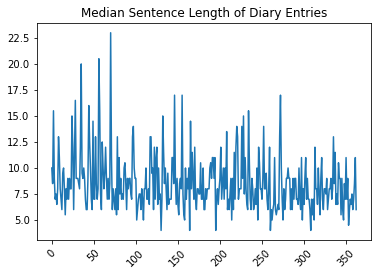

In [ ]:
# plotting things, just to see
plt.plot(range(0, 363), winnie_stats['sentence_length_median'])
plt.xticks(rotation='45')
plt.title("Median Sentence Length of Diary Entries")
plt.show()

## [Dependency Distance](https://hlasse.github.io/TextDescriptives/dependencydistance.html)

Dependency distance is the "linear distance between two syntactically related words in a sentence" ([Liu 2017](https://www.sciencedirect.com/science/article/pii/S1571064517300532)), and can be used to indicate syntactic complexity or difficulty of a sentence ([Liu 2008](https://pdfs.semanticscholar.org/b6b9/cf00698a76d7a1e5ba58baa92d8799366813.pdf), [Oya 2010](http://www.paaljapan.org/conference2011/ProcNewest2011/pdf/poster/P-13.pdf), [Liu 2017](https://www.sciencedirect.com/science/article/pii/S1571064517300532)). Sentences with larger dependency distances are generally more difficult as the reader has a greater "memory burden". 

`TextDescriptives` can calculate the following measures of dependency distance: 
- For `Doc` objects
    - mean and standard deviation of dependency distance for sentences
    - mean and standard deviation of "proportion adjacent dependency relations" for sentences
- For `Span` objects 
    - mean dependency distance and "mean proportion adjacent dependency relations" 
- For `Token` objects
    - dependency distance
    - whether the dependency relation is an adjacent token



In [ ]:
td.extract_df(doc, metrics="dependency_distance")

,text,dependency_distance_mean,dependency_distance_std,prop_adjacent_dependency_relation_mean,prop_adjacent_dependency_relation_std
0,"New Year. First day of 1900 Charlie Merritt died at Grand Forks British Columbia yesterday of typhoid fever. To-day is election day and pap went up about 3 o'clock and did not get back until nearly 10. He brought us some candy chocolate drops. We had a very fat goose for dinner, not a very young one. Had to have good teeth.",2.09258,0.737249,0.501575,0.10528


# Miscellaneous: Entity Linking + Knowledge Bases

You can train spaCy to be able to use context to disambiguate text mentions of entities to "real-world" entities stored in a knowledge base. There is a [tutorial on this concept/topic by one of the main spaCy contributers](https://spacy.io/universe/project/video-entity-linking). The example used in the tutorial is disambiguating a mention of the name "Emerson" in a text about winning a tennis championship. Suppose there are 3 people whose names are Emerson in your knowledge base, you can train spaCy to use the context (this Emerson must play tennis) to determine which Emerson is being referred to. 